In [1]:
import torch
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import config

In [2]:
if config.USE_UNET: import unet as autoencoder
else: import convolutional_autoencoder as autoencoder

In [3]:
# Load the encoder model
def load_encoder(model_path, device):
    model = autoencoder.AutoEncoder()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.encoder
    model = model.to(device)
    return model

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
autoencoder_save_path = 'best_models/h1_80-10-10_Autoencoder.pth'  # Replace with your actual encoder path
encoder = load_encoder(autoencoder_save_path, device)
encoder.to(device)
encoder.eval()

Encoder(
  (e11): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e12): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e22): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e32): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e41): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e42): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e51): Conv2d(64, 128, kernel_size=(3, 3), stride=

In [6]:
data_transforms = {
    'all': transforms.Compose([
           transforms.Resize((224, 224)),
           transforms.ToTensor()
  	]),
}

In [7]:
full_dataset = datasets.ImageFolder(config.BASE_DIR_NOISY if config.USE_DENOISING_AUTOENCODER else config.BASE_DIR_RAW, transform=data_transforms['all'])

In [8]:
indices = list(range(len(full_dataset)))

# Get the directory paths of images
image_paths = [sample[0] for sample in full_dataset.samples]

labels = [os.path.split(os.path.dirname(path))[-1] for path in image_paths]

In [9]:
val_indices, train_indices = train_test_split(indices, test_size=0.8, stratify=labels, random_state=42)

In [10]:
train_dataset = Subset(full_dataset, train_indices)
data = DataLoader(train_dataset, batch_size=config.AE_BATCH_SIZE, shuffle=False)

tsne_labels = []
latent_vectors = []

with torch.no_grad():
  i = 0
  for image, label in tqdm(data):
    tsne_labels.append(label.numpy())
    image = image.to(device)
    latents = encoder(image)
    
    if config.USE_UNET:
       latents = latents[4].cpu().numpy()
    else:
       latents = latents.cpu().numpy()
	   
    latent_vectors.append(latents.reshape(latents.shape[0], -1))
    i += 1
    if i >= 100:
      break

 23%|██▎       | 99/422 [00:05<00:16, 19.11it/s]


In [11]:
latent_vectors = np.concatenate(latent_vectors, axis=0)
labels = np.concatenate(tsne_labels, axis=0)

/tmp/ipykernel_10386/2212557025.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


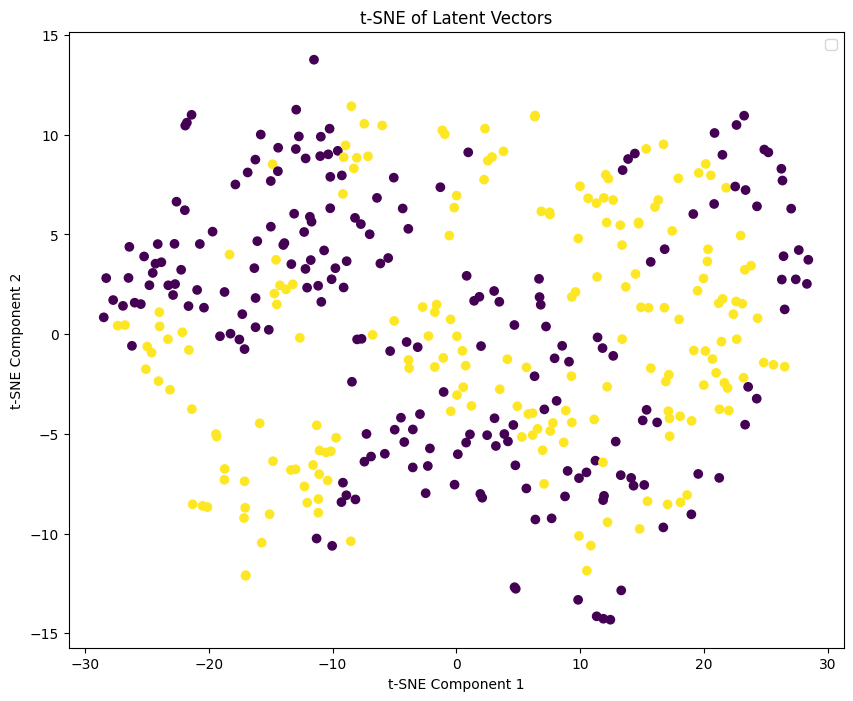

In [12]:
# Apply PCA
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(latent_vectors)

# Plot the results
plt.figure(figsize=(10, 8))

scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='viridis')

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE of Latent Vectors')
plt.legend()
plt.show()

In [13]:
writer = SummaryWriter('runs/latent_vectors')

np.savetxt('metadata.tsv', labels, delimiter='\t')
np.savetxt('latent_vectors.tsv', latent_vectors, delimiter='\t')

writer.add_embedding(latent_vectors, metadata=labels)
writer.close()